<a href="https://colab.research.google.com/github/dimaknyaz/MLTuring/blob/master/Final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We (Dmitriy Knyazhitskiy, Ming Cheng, Rohan Ghosh) would like to start with a brief description of what is going to happen next.

First I would like to notice that Ming and Rohan were not able to continue this project, so it was made 90% by me. Hope you'll take this fact into account. I don't mind if they'll also get credits because they both were very passionate about the project in the begging, then Rohan was in Hospital for 1.5 months and Ming had some personal issues.

Our aim was to compare several algorithms for predicting stock prices of Tesla (or any other company) for the next day.

Not all criteria are applicable to our models. The dimensionality reduction is impossible in our case. However, even strictly following your criteria under the assumption that the last model doesn't count as only the final algorithm with no optimisation is presented, we still should have enough points.

We would like to start with a notice about our models: we have 2 neural networks and one simple algorithm which is performed as not a machine learning, however, it uses the coefficients that were obtained by means of the unsupervised learning model.







## **1.Data**

#*Data collection*
We have spent a lot of time it the begging searching for data:

First, we obtained data from Bloomberg Terminals that was not an easy problem due to the absolute lack of documentation on how to use the terminal. However, later we found out that this data is not complete - of course, it's much more precise than the one we can get with open resources, but some points were missing and it makes a lot of complication for time series analysis etc.

Then we decided to make us of Alpha Vantage , but this recourse only provides a limited amount of data.

So, finally, we sticked to the yahoo finance.

In [0]:
import pandas_datareader as web
df = web.DataReader('TSLA', data_source='yahoo', start='2012-01-01', end='2020-03-21')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,29.500000,27.650000,28.940001,28.080000,928100,28.080000
2012-01-04,28.670000,27.500000,28.209999,27.709999,630100,27.709999
2012-01-05,27.930000,26.850000,27.760000,27.120001,1005500,27.120001
2012-01-06,27.790001,26.410000,27.200001,26.910000,986300,26.910000
2012-01-09,27.490000,26.120001,27.000000,27.250000,897000,27.250000
...,...,...,...,...,...,...
2020-03-16,494.869995,442.170013,469.500000,445.070007,20489500,445.070007
2020-03-17,471.850006,396.000000,440.010010,430.200012,23994600,430.200012
2020-03-18,404.859985,350.510010,389.000000,361.220001,23786200,361.220001


#*Exploratory Data Analysis*

On plot of Tesla we can see the rapid growth and then the failure the crisis

Fun fact: the volatility for the last 100 days almost 2 times higher that for the period starting at 2012

Also, you may notice a huge increase of price in 2018-2019 that implied that "naive" trading strategy performed so well




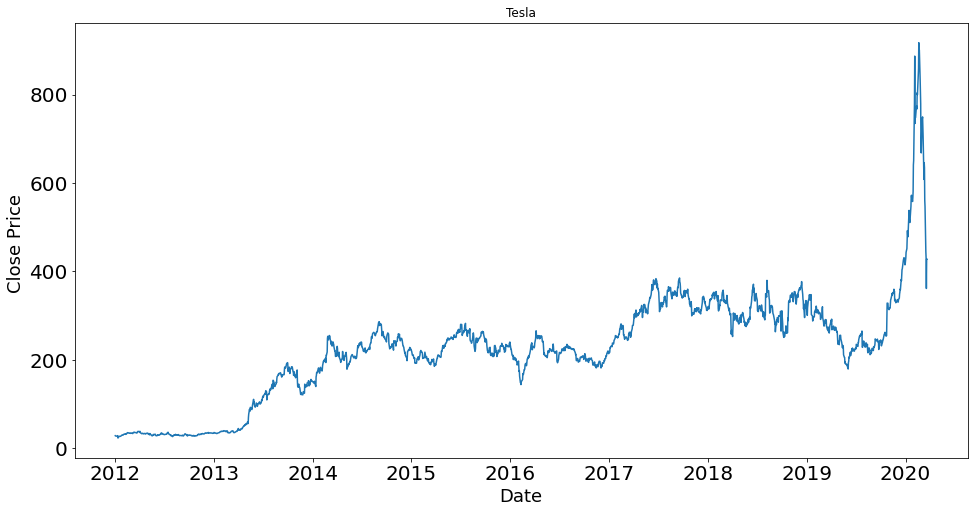

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.title('Tesla')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price ', fontsize=18)
plt.show()

In [0]:
x = df["Close"][:-100].std()
y = df["Close"][-100:].std()
print (y/x)

1.8291810626749052


##**2.Models**##




**1. 2 layer, 50 neurons each, (and 2 hidden layers) Long Short-Term Memory network**

We train it for 8 years after that predict next day closing price based on 200 previous days. So, we want to find out if it's possible to get a nice prediction based on only closing price.


In [0]:
import math

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [0]:
data = df.filter(['Close'])
#Convert our dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = (int)( len(dataset) -200 )

# let's make our data ~ N(0,1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)


#Create the scaled training data set
train_data = scaled_data[0:training_data_len , :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(200, len(train_data)):
  x_train.append(train_data[i-200:i, 0])
  y_train.append(train_data[i, 0])
 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Next, we train our model. Notice that it takes couple of minutes to execute the code.

In [0]:
# Train our model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)
#Create the testing data set

test_data = scaled_data[training_data_len - 200: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(200, len(test_data)):
  x_test.append(test_data[i-200:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

Epoch 1/1
1667/1667 [==============================] - 186s 112ms/step - loss: 5.8232e-04


Next we will apply a very common metric RMSE.
For this model $RMSE = 47.1$
But it doen't provides us with much information



In [0]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

std=np.sqrt(np.mean(((predictions- y_test)**2)))
print ("The standart deviation (Root-mean-square deviation) for prediction is " + str(std) )

The standart deviation (Root-mean-square deviation) for prediction is 49.63494098201656


Let's plot our model. Looks like it works, right?


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


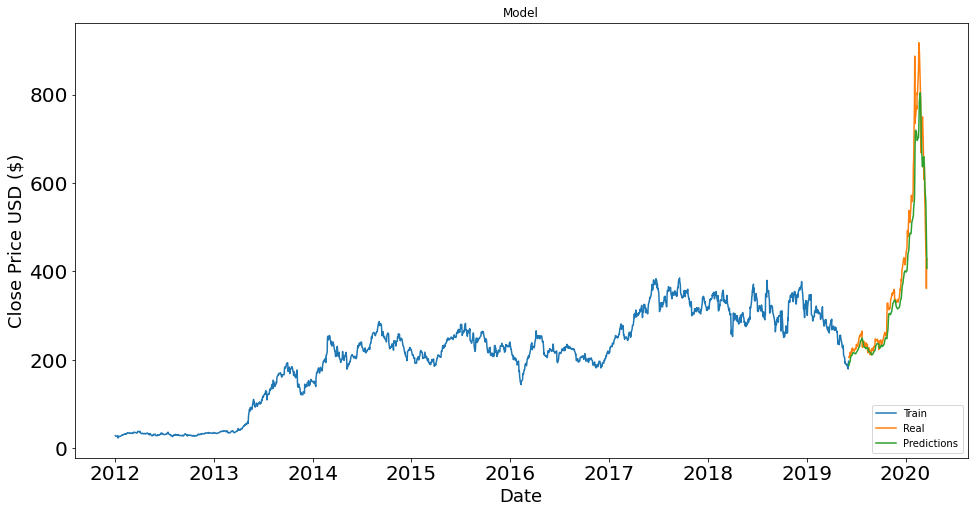

In [0]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Real', 'Predictions'], loc='lower right')
plt.show()


Yes, but no.

Take a closer look

<function matplotlib.pyplot.show>

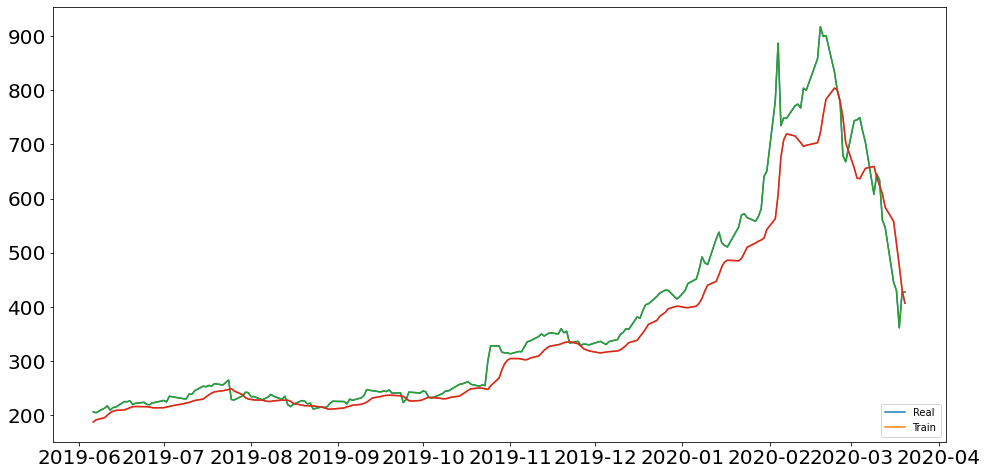

In [0]:
valid[-200:]
plt.figure(figsize=(16,8))
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Real','Train'], loc='lower right')
plt.plot(valid)
plt.show

It looks like the model predicts a price for tommorow very much based on price for today. In fact, it makes sense if we think about stock pricing as a completely random process.

We'll implement some analysis of obtained results later.


In [0]:
# for results part
corr = 0
for i in range (1,200):
    s1=np.sign(valid.iloc[i]["Close"]- valid.iloc[i-1]["Close"])
    s2=np.sign(predictions[i]- valid.iloc[i-1]["Close"])
    if s1!=s2:
        corr=corr+1       
print ("our prediction is correct with probability " + str(corr/(len(valid)-1)))

our prediction is correct with probability 0.5577889447236181


**2. Network with binary predicitions based on comparison of Tesla perfomance with S&P500, NASDAQ-100 Technology Sector, Dow Jones Industrial Average.** 

Based on 4 layers, It's expected to find correlations beetwen diffrent markets, also including maximal and minimal day price.

We can't draw fancy graphs here because of the binary predictions


In [0]:
from pandas_datareader import DataReader
import numpy as np
import pandas as pd

import datetime

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, GaussianNoise

import matplotlib.pyplot as plt
# names of indicators we're looking for
symbols = ["TSLA", "^GSPC", "^NDXT", "^DJI"]

To make our life easier and fancier let's write functions that do authomatically collect data and then look for the dayly change and take it's sign of change (either consider vector (1,0) or (0,1)). We will also analyse the highest or the lowest price of the last day.

In [0]:
def getStock(pair, startdate = '2010-01-01', enddate = '2020-05-18'):
  data = DataReader(pair, 'yahoo', start=startdate, end=enddate)
  data.reset_index(inplace=True, drop=False)
  return data

def generate(dataRaw, trainX = [], trainY = []):
  
  date = []
  for i in range(len(dataRaw)):
    date.append((datetime.datetime.strptime(str(dataRaw["Date"][i]).split()[0], "%Y-%m-%d")).toordinal())

  # Calculate truly values of input data
  data = []
  for i in range(len(dataRaw)):
    cl = dataRaw["Close"][i]
    op = dataRaw["Open"][i]
    mn = dataRaw["Low"][i]
    mx = dataRaw["High"][i]

    data.append([(cl - mn) / mn, (op - mn) / mn, (mx - mn) / mn])

  # Transform old input train data from numpy array to lists
  if (isinstance(trainX, np.ndarray)): trainX = trainX.tolist()
  if (isinstance(trainY, np.ndarray)): trainY = trainY.tolist()
  trulyPrices = []

  for i in range(len(dataRaw) - 1):
    # If it is a normal day
    if date[i] + 1 == date[i + 1]:
      # Add data
      trainX.append(data[i])

      # Calculate next movement of price
      if dataRaw["Close"][i] > dataRaw["Close"][i + 1]:
        trainY.append([1, 0])
      else:
        trainY.append([0, 1])
      
      # Add close price for current place
      trulyPrices.append([dataRaw["Close"][i], dataRaw["Close"][i + 1]])

  trainX = np.array(trainX)
  trainY = np.array(trainY)

  trulyPrices = np.array(trulyPrices)

  return trainX, trainY, trulyPrices

In [0]:
getStock("TSLA") # Wow, it works

,Date,High,Low,Open,Close,Volume,Adj Close
0,2010-06-29,25.000000,17.540001,19.000000,23.889999,18766300,23.889999
1,2010-06-30,30.420000,23.299999,25.790001,23.830000,17187100,23.830000
2,2010-07-01,25.920000,20.270000,25.000000,21.959999,8218800,21.959999
3,2010-07-02,23.100000,18.709999,23.000000,19.200001,5139800,19.200001
4,2010-07-06,20.000000,15.830000,20.000000,16.110001,6866900,16.110001
...,...,...,...,...,...,...,...
2484,2020-05-12,843.289978,808.000000,827.000000,809.409973,15906900,809.409973
2485,2020-05-13,826.000000,763.299988,820.830017,790.960022,19065500,790.960022
2486,2020-05-14,803.359985,764.000000,780.000000,803.330017,13682200,803.330017
2487,2020-05-15,805.049988,786.549988,790.349976,799.169983,10518400,799.169983


In [0]:
trainX = []
trainY = []

for i in symbols:
      trainX, trainY, _ = generate(getStock(i), trainX, trainY)
   
# let's see how our training sets look
trainX.shape, trainY.shape

((8073, 3), (8073, 2))

In [0]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(3, )))
model.add(GaussianNoise(1e-6))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='softmax'))

import keras.optimizers as opt

model.compile(loss='mean_squared_error',
                optimizer=opt.Adam(lr=3e-4),
                metrics=['accuracy'])

In [0]:
history = model.fit(trainX, trainY,
            epochs=50,
            batch_size=128)


Epoch 1/50
8073/8073 [==============================] - 0s 29us/step - loss: 0.2493 - accuracy: 0.5425
Epoch 2/50
8073/8073 [==============================] - 0s 13us/step - loss: 0.2484 - accuracy: 0.5435
Epoch 3/50
8073/8073 [==============================] - 0s 14us/step - loss: 0.2483 - accuracy: 0.5435
Epoch 4/50
8073/8073 [==============================] - 0s 13us/step - loss: 0.2482 - accuracy: 0.5435
Epoch 5/50
8073/8073 [==============================] - 0s 12us/step - loss: 0.2481 - accuracy: 0.5435
Epoch 6/50
8073/8073 [==============================] - 0s 13us/step - loss: 0.2481 - accuracy: 0.5435
Epoch 7/50
8073/8073 [==============================] - 0s 13us/step - loss: 0.2480 - accuracy: 0.5435
Epoch 8/50
8073/8073 [==============================] - 0s 12us/step - loss: 0.2481 - accuracy: 0.5435
Epoch 9/50
8073/8073 [==============================] - 0s 12us/step - loss: 0.2480 - accuracy: 0.5435
Epoch 10/50
8073/8073 [==============================] - 0s 13us/step - l

In [0]:
testX, testY, testPrices = generate(getStock("TSLA", '2010-05-05', '2020-05-18'), [], [])
model.evaluate(testX, testY, verbose = 0)

[0.2503126344326711, 0.5138745903968811]

In [0]:
def predict(data):
  ans = model.predict([[data]])[0]
  return (ans[1] - ans[0])

Finally, we can get result of our predictions: the sign of result[i] schould tell the sighn of price change for the last 200 days 


In [0]:
result=np.empty(len(testX))
for i in range(len(testX)):
  result[i] = predict(testX[i])

for i in range(1,len(testX)):
  result[i] = result[i]-result[i-1]

print (result[0:-200])

[-0.1285623   0.14323163 -0.1468114  ... -0.47784257  0.58064765
 -0.47799915]


In [0]:
# test part for "results"
valid = getStock("TSLA", '2019-01-01', '2020-05-18') # doesn't matter if it's more than 60 days, I only consider last 60
corr = 0
for i in range (len(valid)-200,len(valid)):
    trend=np.sign(valid.iloc[i-1]["Close"]- valid.iloc[i-2]["Close"])
    s2=np.sign(result[i]- valid.iloc[i-1]["Close"])
    if trend!=s2:
        corr=corr+1       
print ("The strategy works with probability  " + str(corr/(200-1)))

The strategy works with probability  0.5628140703517588


**Hyperparameter Tuning**

How to choose optimal parameters and optimal architecture for networks?

To determine the number of layers and neurons, I read an article here https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046.

Also we have tried models with more hidden layers, but the precision of pprediction didn't cahnge when number of layers/neurons incresed.

Also, I based the parameters values on simular projects. See links in the end.



## **3.Results**

**Model selection**

Here, the choice of metrics used is quite natural - let's see how the algorithms will perform during the last 200 days. By performance, we mean the share of days when the binary prediction is correct. 

Also, would you be interested, I wrote a simple (non-machine learning) trading strategy based on going against the short market trends and we can compare its performance with the performance of our ML algorithms. It is the simple model I talked about in the beggining


The simple strategy:

In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
valid = web.DataReader('TSLA', data_source='yahoo', start='2010-01-01', end='2020-05-18')


In [0]:
interv = 1;
def up(i):
    if (np.sign(valid.iloc[i-1]["Close"]- valid.iloc[i-1-interv]["Close"])) > 0:
        return True
    return False 

In [0]:
account = []
leng = 1;
money = 10000;
bucks = money
def trade(i):
    global money
    if up(i)==False: # then I buy
        money = money +( - valid.iloc[i]["Close"]+ valid.iloc[i+leng]["Close"])*(int (money / valid.iloc[i]["Close"]))
        return money
    if up(i) == True:# then I sell
        money = money + (valid.iloc[i]["Close"] - valid.iloc[i+leng]["Close"])*(int (money / valid.iloc[i]["Close"]))
    return money
    

In [0]:
profData = [];
for i in range (2,len(valid)-1):
    profData.append(100*(trade(i)/bucks - 1))


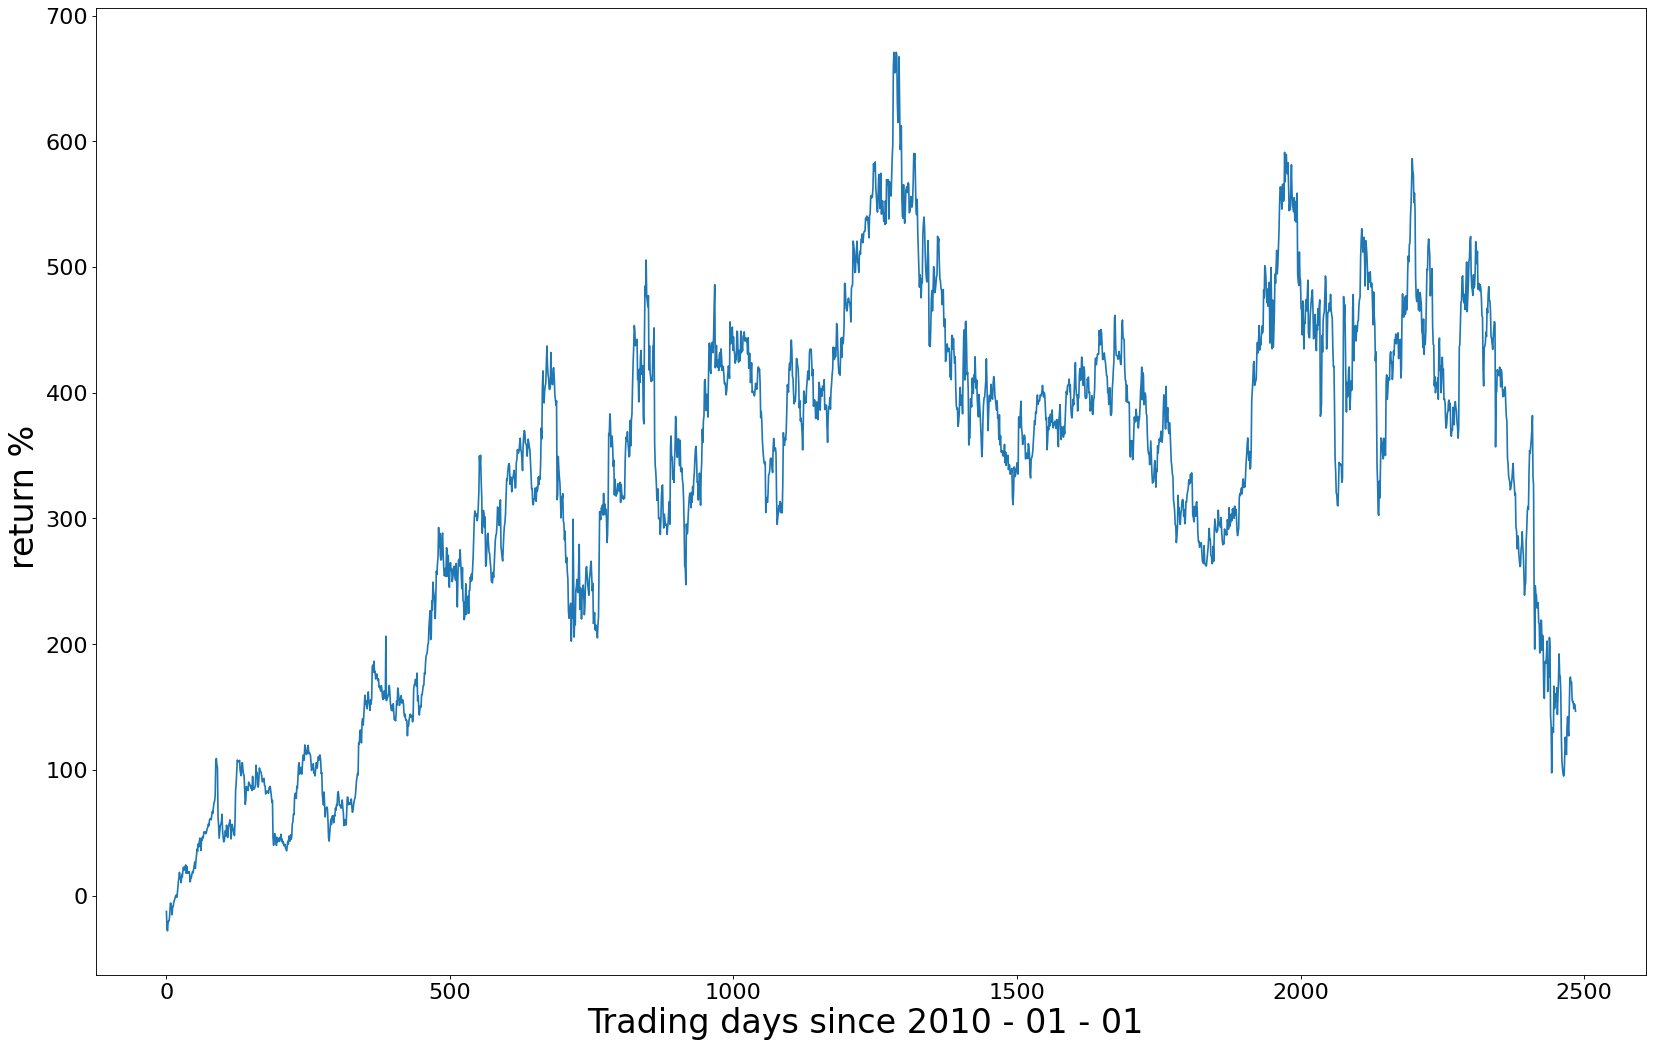

In [0]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(25, 16), dpi=80, facecolor='w', edgecolor='k')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.ylabel('return % ', fontsize = 30)
plt.xlabel('Trading days since 2010 - 01 - 01 ', fontsize = 30)
plt.plot ((profData[:]))
plt.show()

We can see that the perfomance is quite good, but it is the case because of TSLA, if we perform this algoritm to SP500 instead it will generate cumulative 30% on top.
The most important thing we see here that the perfomance over last 200 days is very poor. 

Now let's see how good it will "guess" the direction of price change 

In [0]:
corr = 0
for i in range (len(valid)-200,len(valid)):
    trend=np.sign(valid.iloc[i-1]["Close"]- valid.iloc[i-2]["Close"])
    s2=np.sign(valid.iloc[i]["Close"]- valid.iloc[i-1]["Close"])
    if trend==s2:
        corr=corr+1       
print ("The strategy works with probability  " + str(corr/(200-1)))


The strategy works with probability  0.507537688442211


So, this is our benchmark: 50.7% of correct predictions

If I put code here, for this in both models it will become complicated mess, so I put code for this "Models" part.

For the first network, it gives the right conclusion in 55.8% of cases. It's very simular to the simple trading alghoritm you can see above.

For the second network, the amount of correct predictions is 56.3%.


**Interpretation**

What we found out:

The best result is performed by the most complicated network. It's of course expectable, as it include more factors than the other one. However, the difference is really small, we can say that they perfomed equally good. This can can explained as that it case of advanced network some of the data is irrelevant, so it makes our prediction more noisy.

The nice fact is that they both work better than simple alghoritm

**Validation**

The idea behind the 200-day interval was that we should be able to distinguish outcomes that differ for at least 5% with a probability of 90%.

So, if the difference between "naive" forecast and ML forecast is at least 5% we can conclude that actually work.  Good news - it's the case.

First we got an upper bound for the variance - for variance on any pdf defined on $[a;b]$: $$Var(X)\leq \frac{b^2-a^2}{4}$$
We give a binary prediction, Hence for our case, we can say that $\sigma_{max} = 0.5$

To obtain a limiting distribution using CLT we say that $$\bar{x} \sim N(\mu, \frac{1}{4n})$$

Then we can use one-sided (worse than random is not the case to consider) interval to get that our prediction is valid with the probability of 93%!

And it's only the very bad case because in fact, we expect our variance to be lower

**Discussion**

There are many ways to improve these models and I actually consider to implement them in the future. 

First, it's possible to use market sentiment and other indicators. 

Second, we might consider data for short intervals of time, because it's possible to find more relations between different indices.

Finally, it would be very interesting to connect these predictions with news analysis.

Also, it is possible to try actual trading with mock money on platforms like https://www.quantopian.com/

**4.Reflection**
We had troubles with:

*   Colleting data. Even if data was finally taken from online resourse, we tried a lot in attempt to find a more precise data.


*   Model fitting, I sounds silly, but I had a lot of troubles to understand data in what dimenions should I use

* Understanding what actually is going on. It's possible to make these networks work, but I had questions general like "what LSTM actually does", or "Why everybody using adam optimiser, and what/how it works".







As for task/problem I can simply describe how I wrote a first network.

When I came to the first or second tutorial we were taught the optimisation algorithm based on eigenvalues. It was fun for me because I learned about the eigenvalues on the same day a few hours earlier. (Yes, I'm a first-year student:).

And then we were talking about the actual algorithms when I more expected a theoretical course on what consists of. So, for the first few weeks, I was following tutorials/googling a lot of stuff to get an impression of what is going. Then I tried to write my own network, and it obviously didn't work and gave some weird mistakes. Of course, after some time I figured out why. These first few steps were the most challenging for me.

Finally, the review:

I liked it. And I liked the most lectures from Vikram. They are easy to understand and very informative.

Personally I would be more interested in first gaining more theoretical knowledge and then applying it. However, I should admit that the approach we had on this course resulted in both.

One of the implications of project-based activities that I'm really thankful is that my coding abilities increased a lot.

I would like to mention that some people were not able to finish it because of Corona and I'm sure that my and other teams would be able to do more and better in normal circumstances.

# Links to external resourses:

https://towardsdatascience.com/what-are-hyperparameters-and-how-to-tune-the-hyperparameters-in-a-deep-neural-network-d0604917584a

https://towardsdatascience.com/aifortrading-2edd6fac689d

https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

https://towardsdatascience.com/machine-learning-techniques-applied-to-stock-price-prediction-6c1994da8001

https://medium.com/swlh/coding-your-way-to-wall-street-bf21a500376f



**Thanks for your attention!**